In [1]:
import cvxpy as cvx
import numpy as np

import matplotlib.pyplot as plt
from scipy import signal
import random
from sklearn.metrics import mean_absolute_error as mae

from utils import plot_decomp, plot_signal

np.random.seed(12) 
random.seed(10)

In [2]:
from gfosd import Problem
from gfosd.components import *

## `l1_l2d2p365`

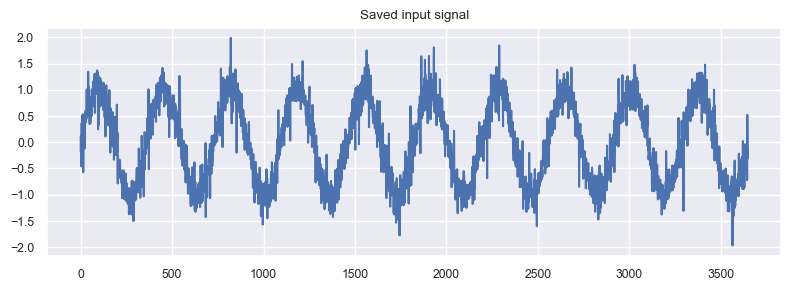

In [3]:
t = np.arange(365*10)

# seasonal periodic
signal1 = np.sin(2 * np.pi * t * 1 / (365.))
X_real = np.zeros((2, len(t)), dtype=float)
# laplacian noise
signal2 = 0.15 * np.random.laplace(0, 1, len(signal1))

X_real[0] = signal1
X_real[1] = signal2

y = np.sum(X_real, axis=0)
plot_signal(y)

In [4]:
def l1_l2d2p365(
        signal,
        c1=1e3, # val ok
        yearly_periodic=True, # default not overwritten in calls
        solver="MOSEK",
        verbose=False,
        s_seas_osd=None # for calculating OSD equivalent objective
):
    x = cvx.Variable(len(signal))

    objective = cvx.Minimize(
        cvx.norm1(signal - x) + c1 * cvx.norm(cvx.diff(x, k=2))
    )

    if len(signal) > 365 and yearly_periodic:
        constraints = [x[365:] == x[:-365]]  # does this only force the first 365 elements of x[365:] to be equal to the first 365 of x?
    else:
        constraints = []

    problem = cvx.Problem(objective, constraints=constraints)

    problem.solve(solver=solver, verbose=verbose)
    
    if s_seas_osd is not None:
        print(f"CVXPY objective       {problem.objective.value:.5f}")
        x.value = s_seas_osd
        print(f"OSD objective, scaled {problem.objective.value:.5f}")
        return problem.objective.value

    return x.value, problem.objective.value

In [5]:
x_cvxpy_mosek, obj_cvxpy_mosek = l1_l2d2p365(y)

In [6]:
obj_cvxpy_mosek

548.0188022211371

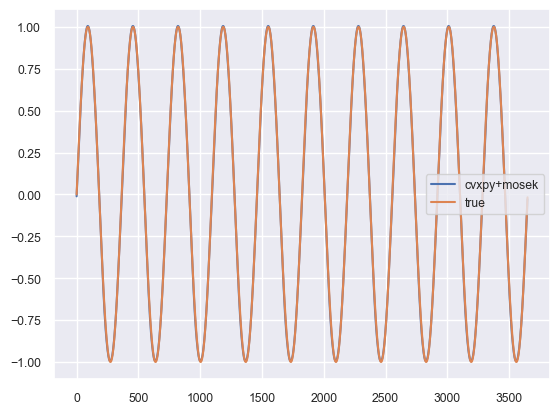

In [7]:
plt.plot(x_cvxpy_mosek, label="cvxpy+mosek")
plt.plot(X_real[0], label="true")
plt.legend();

In [11]:
def gfosd_l1_l2d2p365(
        signal,
       # c1=1e3, # val ok
        yearly_periodic=True, # default not overwritten in calls
        verbose=False
):
    '''
    - l1: laplacian noise, sum-of-absolute values or l1-norm
    - l2d2p365: small second order diffs (smooth) and 365-periodic
    '''

    c1 = SumAbs(1/len(signal)) # cost function for Laplace noise is simply the sum of the absolute values, or the L1 norm.
    c2 = SumSquare(weight=120, diff=2)
    
    if len(signal) > 365 and yearly_periodic:
        c2 = Aggregate([c2, Periodic(365)])

    classes = [c1, c2]
    
    problem = Problem(signal, classes)
    
    problem.decompose(solver='MOSEK', verbose=verbose)
    s_error =  problem.decomposition[0]
    s_seas = problem.decomposition[1]

    return s_seas, s_error, problem.objective_value

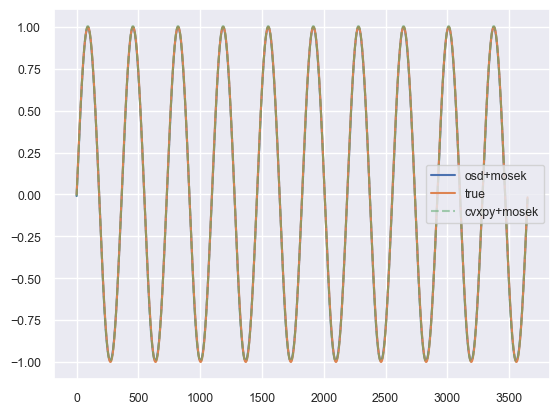

In [12]:
x_osd_mosek, err_osd_mosek, obj_osd_mosek = gfosd_l1_l2d2p365(y)

plt.plot(x_osd_mosek, label="osd+mosek")
plt.plot(X_real[0], label="true")
plt.plot(x_cvxpy_mosek, linestyle="--", alpha=0.5, label="cvxpy+mosek")

plt.legend();

### Weight = 120 (optimal for len(signal)=365*3)

In [40]:
obj_osd_scaled = l1_l2d2p365(y, s_seas_osd=x_osd_mosek) 
print(f's_hat MAE MOSEK OSD/CVX   {mae(x_osd_mosek, x_cvxpy_mosek):.2e}')

CVXPY objective       169.26643
OSD objective, scaled 169.26662
s_hat MAE MOSEK OSD/CVX   1.30e-04


### Weight = 220 (optimal for len(signal)=365*2)

In [43]:
obj_osd_scaled = l1_l2d2p365(y, s_seas_osd=x_osd_mosek) # weight = 220 
print(f's_hat MAE MOSEK OSD/CVX   {mae(x_osd_mosek, x_cvxpy_mosek):.2e}')

CVXPY objective       169.26643
OSD objective, scaled 169.31206
s_hat MAE MOSEK OSD/CVX   1.63e-03


### Weight = 220 and len(signal)=365*2

In [10]:
obj_osd_scaled = l1_l2d2p365(y, s_seas_osd=x_osd_mosek) # weight = 220 
print(f's_hat MAE MOSEK OSD/CVX   {mae(x_osd_mosek, x_cvxpy_mosek):.2e}')

CVXPY objective       114.34820
OSD objective, scaled 114.34829
s_hat MAE MOSEK OSD/CVX   9.98e-05


### Weight = 220 and len(signal)=365*10 (OSD takes a while to run compared to CVXPY)

In [10]:
obj_osd_scaled = l1_l2d2p365(y, s_seas_osd=x_osd_mosek) # weight = 220 
print(f's_hat MAE MOSEK OSD/CVX   {mae(x_osd_mosek, x_cvxpy_mosek):.2e}')

CVXPY objective       548.01880
OSD objective, scaled 548.78161
s_hat MAE MOSEK OSD/CVX   6.52e-03


### Weight = 120 and len(signal)=365*10 (OSD takes a while to run compared to CVXPY)

In [13]:
obj_osd_scaled = l1_l2d2p365(y, s_seas_osd=x_osd_mosek) # weight = 220 
print(f's_hat MAE MOSEK OSD/CVX   {mae(x_osd_mosek, x_cvxpy_mosek):.2e}')

CVXPY objective       548.01880
OSD objective, scaled 548.33161
s_hat MAE MOSEK OSD/CVX   3.76e-03


- Estimated component should should be exactly the same with MOSEK --> weight improves this, but is not the same?
- I tuned by hand while minimizing MAE
- are these weights robust to other data? (eg will the comparison remain good with a different dataset?)
    - seems to vary now when I vary signal length, **significantly enough to have MAE>1e-3**
    - check this with experiment with signal to noise variations and length variations
    - maybe generate 10 random signals and check variance